---

## 07 - Fast Fourier Transform
The previous two notebooks introduced Fourier's Theorem and the DFT. Throughout this notebook, we will investigate a technique that speeds up the computation of the DFT, known as the Fast Fourier Transform (FFT). We will begin by understanding the Danielson-Lanczos Lemma and then implement an FFT design from first principles that will serve as an example. We will briefly explore the Numpy FFT module, before finishing with a short introduction to the Short-Time Fourier Transform (STFT).

## Table of Contents
* [1. Introduction](#introduction)
* [2. The Fast Fourier Transform](#fft)
    * [2.1. Danielson-Lanczos Lemma](#dll)
    * [2.2. Decimation in Time](#dit)
    * [2.3. An FFT Example](#fft-example)
    * [2.4. FFT Versus DFT](#fft-dft)
    * [2.5. The Numpy FFT Module](#numpy-fft-module)
* [3. Short-Time Fourier Transform](#stft)
    * [3.1. STFT of a Chirp](#stft-of-a-chirp)

## References
* [1] - [J. W. Cooley and J. W. Tukey, "An Algorithm for the Machine Calculation of Complex Fourier Series," Mathematics of Computation, Vol. 19, No. 90, 1965, pp. 297-301.](https://doi.org/10.2307/2003354)
* [2] - [G. C. Danielson and C. Lanczos, "Some improvements in practical Fourier analysis and their application to X-ray scattering from liquids," Journal of the Franklin Institute, Vol. 233, Issue 4, 1942, pp. 365-380.](https://doi.org/10.1109/ACSSC.2006.354945)

---


## 1. Introduction <a class="anchor" id="introduction"></a>
To begin our investigation into the FFT, we will first redefine the DFT function from the [previous notebook](06_investigating_the_dft.ipynb).

In [1]:
import numpy as np

def dft(x):
    N = np.size(x)
    X = np.zeros(N, dtype=np.complex64)
    n = np.arange(0, N)
    for k in range(N):
        X[k] = np.sum(x*np.exp(-2j*np.pi*k*n/N))
    return X

For the purpose of plotting, we will also reintroduce the `stem_plot` function.

In [2]:
import matplotlib.pyplot as plt

def stem_plot(x, y, title, xlabel, ylabel, xticks=None, yticks=None, figsize=(6, 3), subplot=(1, 1), bottom=None, style=None):
    fig = plt.figure(figsize=figsize)
    for idx, value in enumerate(y):
        axes = fig.add_subplot(subplot[0], subplot[1], idx+1)
        if bottom is not None:
            axes.stem(x[idx], y[idx], use_line_collection = True, bottom=bottom[idx])
        else:
            axes.stem(x[idx], y[idx], use_line_collection = True)
        if style is not None:
            if style[idx] == 'dashed':
                axes.plot(x[idx], y[idx], linestyle='dashed')
        axes.grid(True, which='major')
        if xticks is not None:
            axes.set_xticks(xticks[idx])
        if yticks is not None:
            axes.set_yticks(yticks[idx])
        axes.set_title(title[idx])
        axes.set_xlabel(xlabel[idx])
        axes.set_ylabel(ylabel[idx])
        plt.box(False)

Now, we will generate a discrete waveform to be used as test stimulus when investigating the FFT. The discrete wave will have 8 sample points, a sampling frequency of 48kHz, and consist of 6kHz and 12kHz cosine waves.

In [3]:
fs = 48e3 # Sampling frequency
ts = 1/fs # Regular sampling period
N = 8    # Number of samples
k = n = np.arange(N) # Sample points


a = 0.5*np.cos(2*np.pi*6e3*n*ts + np.pi/4)
b = np.cos(2*np.pi*12e3*n*ts)

x = np.around(a + b, 4)

Lastly, use the `stem_plot` function to plot the discrete wave.

/var/folders/y_/4y9gzpnx6xx2bxstv0jtcl9h0000gn/T/ipykernel_12998/4018461594.py:10: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  axes.stem(x[idx], y[idx], use_line_collection = True)


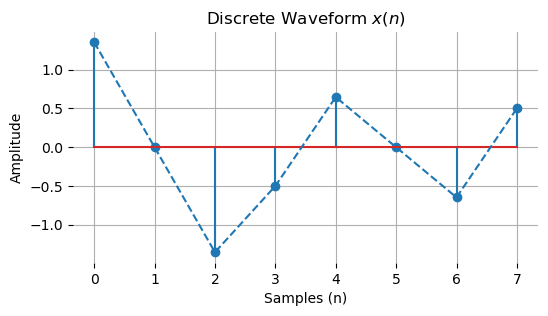

In [4]:
stem_plot(x      = [n],
          y      = [x],
          figsize= (6, 3),
          title  = ["Discrete Waveform $x(n)$"], 
          style  = ["dashed"], 
          xlabel = ["Samples (n)"], 
          ylabel = ["Amplitude"])

## 2. The Fast Fourier Transform <a class="anchor" id="fft"></a>
Large DFTs consume a sizeable amount of processing power to implement. In 1965, Cooley and Tukey [1] described an efficient implementation of the DFT that we now name the Fast Fourier Transform, or FFT. The FFT exploits redundancy in the DFT to reduce the number of arithmetic operations required to obtain the frequency spectra of a discrete time waveform.

In comparison to the DFT, the FFT is approximately 10 times faster and produces the exact same answer.

### 2.1. Danielson-Lanczos Lemma <a class="anchor" id="dll"></a>
To begin, we will explore the Danielson-Lanczos Lemma [2]. Their work describes a technique to compute an N-point DFT by separating it into two smaller size DFTs. This DFT technique is only possible if $N$ is an even number of samples (as we separate the DFT into two DFTs).

The expression below separates the input waveform between two DFTs. One DFT receives all of the even samples of $x(n)$, and the other DFT is allocated the odd samples $x(n)$. Notice that $k$ is still operational across the full range of digital frequencies i.e. $k=0,1,2,...,N-1$.

$$
X(k) = \sum_{n=0}^{N/2-1}x(2n)e^{-j2\pi (2n)k/N} + \sum_{n=0}^{N/2-1}x(2n+1)e^{-j2\pi (2n+1)k/N}
$$

We can rearrange the expression above such that the complex exponential in the odd DFT can be moved outside of the summation, as below.

$$
X(k) = \sum_{n=0}^{N/2-1}x(2n)e^{-j2\pi (2n)k/N} + e^{-j2\pi k/N}\sum_{n=0}^{N/2-1}x(2n+1)e^{-j2\pi (2n)k/N}
$$

Now, we can simply denote the same complex exponential as

$$
W_N^k = e^{-j2\pi k/N},
$$

which is commonly referred to as the twiddle factor. The twiddle factor has a symmetric-periodic property across $N/2$ values, where

$$
W_N^k = -W_N^{k+N/2}.
$$

We can demonstrate this property in the code cell below.

In [5]:
Wk = np.round(np.exp(-2j*np.pi*k/N), 2)

all(Wk[0:N//2] == -Wk[N//2:N])

True

We can rewrite the even and odd DFTs given above as $X^{even}(k)$ and $X^{odd}(k)$, respectively. The expression to compute an N-point DFT using two smaller DFTs now becomes,

$$
X(k) = X^{\text{even}}(k) + W_N^k X^{\text{odd}}(k).
$$

We can express the Danielson-Lanczos Lemma graphically as shown in Figure 1. The figure shown an 8-point DFT implemented using two 4-point DFTs and four multipliers.

<figure>
<img src="../img/fft_a.png" style="width: 75%"/> 
    <figcaption><b>Figure 1: An 8-point DFT that has been implemented using two 4-point DFTs and four multipliers.</b></figcaption>
</figure> 

We can implement an 8-point DFT in software using two smaller 4-point DFTs. Let us start by separating the input waveform into even and odd samples. Also, precompute the twiddle factor for values of $k$ in the range $[0, N/2-1]$.

In [6]:
xeven = x[0::2]
xodd = x[1::2]

W8k = np.exp(-2j*np.pi*k[0:N//2]/N)

Now, perform each 4-point DFT on the even and odd samples. Compute the multiplication of the twiddle factor and odd samples and appropriately add or subtract the result from the even samples.

In [7]:
Xfft = np.zeros(N, dtype=np.complex64)

Xeven = dft(xeven)
Xodd = dft(xodd)

temp = W8k*Xodd
Xfft[0:N//2] = Xeven + temp
Xfft[N//2:N] = Xeven - temp

Plot the results for inspection.

/var/folders/y_/4y9gzpnx6xx2bxstv0jtcl9h0000gn/T/ipykernel_12998/4018461594.py:10: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  axes.stem(x[idx], y[idx], use_line_collection = True)


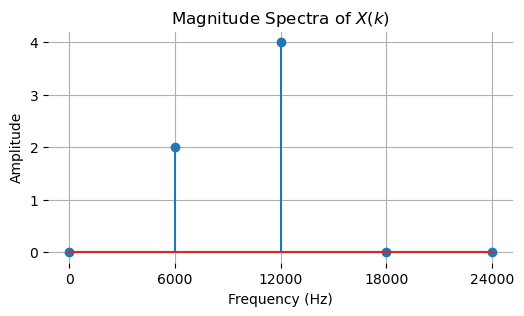

In [8]:
Xfftm = np.abs(Xfft)

stem_plot(x      = [n[0:N//2+1]*fs/N],
          y      = [Xfftm[0:N//2+1]],
          xticks = [n[0:N//2+1]*fs/N],
          figsize= (6, 3),
          title  = ["Magnitude Spectra of $X(k)$"], 
          xlabel = ["Frequency (Hz)"], 
          ylabel = ["Amplitude"])

The resulting magnitude spectra of $X(k)$ appears to be correct as it clearly shows the 6kHz and 12kHz frequency components. We can double-check our result by comparing it to the DFT below.

In [9]:
X = dft(x)
all(np.round(Xfft, 2) == np.round(X, 2))

True

We have demonstrated that separating the DFT into two small DFTs is possible and produces the exact same result. We can now progress further by exchanging the 4-point DFTs for two 2-point DFTs in the next section.

### 2.2. Decimation in Time <a class="anchor" id="dit"></a>
The Danielson-Lanczos Lemma can be applied recursively to remove the two 4-point DFTs in the previous section. This design is presented in Figure 2. The input sequence to the design is further separated into even and odd samples, which is an FFT technique known as decimate-in-time.

<figure>
<img src="../img/fft_b.png" style="width: 100%"/> 
    <figcaption><b>Figure 2: An 8-point DFT that has been implemented using four 2-point DFTs and eight multipliers.</b></figcaption>
</figure> 

As before, we can implement the design above using Python. We begin by separating the input waveform into even and odd sequences. Then, we compute the twiddle factors for $W_4^k$ and $W_8^k$.

In [10]:
xeven_0 = x[0::4]
xodd_0  = x[2::4]
xeven_1 = x[1::4]
xodd_1  = x[3::4]

W8k = np.exp(-2j*np.pi*k[0:N//2]/N)
W4k = np.exp(-2j*np.pi*k[0:N//4]/(N//2))

Now we apply a 2-point DFT to each input sequence. The odd sequencies are appropriately multiplied by the twiddle factor after each stage.

In [11]:
# Initialise registers
Xfft = np.zeros(N, dtype=np.complex64)
Xeven = np.zeros(N//2, dtype=np.complex64)
Xodd = np.zeros(N//2, dtype=np.complex64)

# Apply four 2-point DFTs
Xeven_0 = dft(xeven_0)
Xodd_0 = dft(xodd_0)
Xeven_1 = dft(xeven_1)
Xodd_1 = dft(xodd_1)

# Get Xeven
temp = W4k*Xodd_0
Xeven[0:N//4] = Xeven_0 + temp
Xeven[N//4:N//2] = Xeven_0 - temp

# Get Xodd
temp = W4k*Xodd_1
Xodd[0:N//4] = Xeven_1 + temp
Xodd[N//4:N//2] = Xeven_1 - temp

# Obtain final output
temp = W8k*Xodd
Xfft[0:N//2] = Xeven + temp
Xfft[N//2:N] = Xeven - temp

We can compare the result from the decimate-in-time design and the DFT below.

In [12]:
all(np.round(Xfft, 2) == np.round(X, 2))

True

An additional step for this 8-point DFT would be to apply the Danielson-Lanczos Lemma one last time to reduce the DFT into its final form. This design is the 8-point FFT implementation of the Cooley & Tukey algorithm and is given in Figure 3. It is worth while mentioning that the FFT is only able to process discrete waveforms that are a power of 2 in length.

<figure>
<img src="../img/fft_c.png" style="width: 100%"/> 
    <figcaption><b>Figure 3: An 8-point DFT that has been implemented using twelve multipliers.</b></figcaption>
</figure> 

### 2.3. An FFT Example <a class="anchor" id="fft-example"></a>
The FFT can be implemented using a recursive function to process any power of 2 sized discrete waveform. We have implemented a function below that you can study on your own.

In [13]:
def fft(x):
    N = np.size(x) # Must be a power of 2
    if N == 1:
        return x
    else:
        Xeven = fft(x[0::2]) # Recursion
        Xodd = fft(x[1::2])  # Recursion
        k = np.arange(N)
        X = np.zeros(N, dtype=np.complex64)
        Wk = np.exp(-2j*np.pi*k[0:N//2]/(N))
        temp = Wk * Xodd
        X[0:N//2] = Xeven + temp
        X[N//2:N] = Xeven - temp
        return X

We can use the FFT function above to compute the spectrum of $x(n$ and plot the results for inspection.

/var/folders/y_/4y9gzpnx6xx2bxstv0jtcl9h0000gn/T/ipykernel_12998/4018461594.py:10: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  axes.stem(x[idx], y[idx], use_line_collection = True)


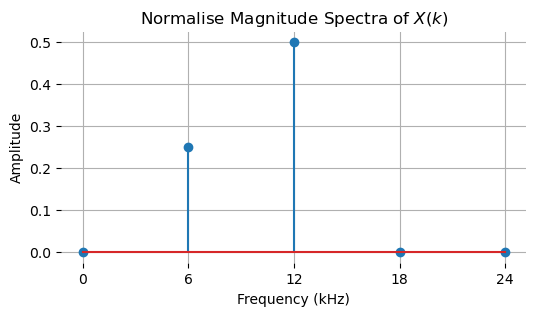

In [14]:
X = fft(x)
Xnorm = np.abs(X)/N

stem_plot(x      = [n[0:N//2+1]*fs/N/1e3],
          y      = [Xnorm[0:N//2+1]],
          xticks = [n[0:N//2+1]*fs/N/1e3],
          figsize= (6, 3),
          title  = ["Normalise Magnitude Spectra of $X(k)$"], 
          xlabel = ["Frequency (kHz)"], 
          ylabel = ["Amplitude"])

Lastly, we can compare the FFT with the DFT and find that the results are the exact same.

In [15]:
all(np.round(fft(x), 2) == np.round(dft(x), 2))

True

### 2.4. FFT versus DFT <a class="anchor" id="fft-dft"></a>
The time required to compute the FFT is significantly faster than the DFT. In this section, we will compare each of our implementations in terms of processing time. Firstly, let us define a test waveform that is 2048 samples long, which means the DFT length is 2048.

In [16]:
N = 2048    # Number of samples
n = np.arange(N) # Sample points

a = 0.5*np.cos(2*np.pi*6e3*n*ts + np.pi/4)
b = np.cos(2*np.pi*12e3*n*ts)

x = np.around(a + b, 4)

Now, compute the execution time of the DFT.

In [17]:
%%time
Xdft = dft(x)

CPU times: user 141 ms, sys: 2.71 ms, total: 144 ms
Wall time: 147 ms


For comparison, compute the execution time of the FFT.

In [18]:
%%time
Xfft = fft(x)

CPU times: user 27.6 ms, sys: 2.6 ms, total: 30.2 ms
Wall time: 30.5 ms


Wow! That was fast! Let us compare both results to check that they are the same.

In [19]:
all(np.round(Xfft, 2) == np.round(Xdft, 2))

True

### 2.5. The Numpy FFT Module <a class="anchor" id="numpy-fft-module"></a>
You should also be aware the Numpy Python library contains FFT support. The module that you will use for the FFT is known as `np.fft`. This module contains several methods for implementing FFT operations. The FFT is implemented using `np.fft.fft`. See the example given in the code cell below.

In [20]:
X = np.fft.fft(x)
Xnorm = np.abs(X)/N

At any point, you can run the following command to get help using the Numpy FFT method.
```python
np.fft.fft?
```
We can plot the results for analysis.

/var/folders/y_/4y9gzpnx6xx2bxstv0jtcl9h0000gn/T/ipykernel_12998/4018461594.py:10: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  axes.stem(x[idx], y[idx], use_line_collection = True)


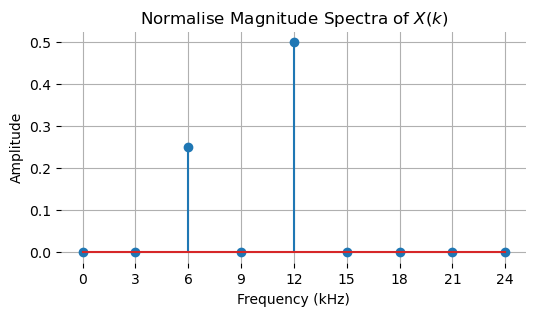

In [21]:
stem_plot(x      = [n[0:N//2+1:128]*fs/N/1e3],
          y      = [Xnorm[0:N//2+1:128]],
          xticks = [n[0:N//2+1:128]*fs/N/1e3],
          figsize= (6, 3),
          title  = ["Normalise Magnitude Spectra of $X(k)$"], 
          xlabel = ["Frequency (kHz)"], 
          ylabel = ["Amplitude"])

You may also be interested in exploring other methods in the `np.fft` module. These are provided below.

```python
np.fft.ifft? # Inverse FFT
np.fft.fftshift? # FFT shift for swapping each half of the FFT
np.fft.fftfreq? # Get the corresponding frequencies for an FFT frame
```

## 3. Short-Time Fourier Transform & Waterfall Plots <a class="anchor" id="stft"></a>

The FFT gives us a lot of insight into sampled signals, and allows us to make many meaningful measurements. However, what if we were also interested in observing how the frequency changes over time? A type of visualization you will often encounter in spectrum analysers, especially in the context of Software Defined Radio (SDR), is the waterfall plot (or spectrogram).

Here we will implement one possible implementation of the Short-time Fourier Transform (STFT), which is essentially chopping up the signal of interest into $L$ number of frames, which are then windowed and passed to an FFT. Later, we can stitch these together into a 2-D image that shows our signal's behaviour over time.

First off, we will create test stimulus. Let's sum several sine waves together across a long observation period.

In [22]:
# Set basic params
fs = 1024 # sample rate
f1 = 60 # frequency of first signal
f2 = 120 # frequency of 2nd signal
f3 = 250 # frequency of 3rd signal
N  = 512 # fft size

L = N*256 # we want 256 frames of 512 FFT windows

# create a sampled sinusoid and corresponding frequencies for plotting
sine_1 = np.sin(2*np.pi*f1*np.arange(L)/fs)
sine_2 = 0.5*np.sin(2*np.pi*f2*np.arange(L)/fs)
sine_3 = 0.7*np.sin(2*np.pi*f3*np.arange(L)/fs)

sum_of_tones = sine_1 + sine_2 + sine_3

We will reshape our sum of tones signal, so that it contains 256 frames of length 512.

In [23]:
sum_of_tones = sum_of_tones.reshape(-1,N)
sum_of_tones.shape

(256, 512)

The Numpy FFT is applied to all the frames in our array. Once again, we will only be looking at the positive side of the spectrum.

In [24]:
# Compute FFT and calculate the PSD
X = np.fft.fft(sum_of_tones*np.hamming(N), N)[:,:int(N/2)]
Xlog = 10*np.log10(2*np.abs(X)**2/N)

# Get corresponding frequencies, take only positive spectrum
freqs = np.fft.fftfreq(N,1/fs)[:int(N/2)]

Now we can plot the log-scale power spectrum over time. Since we are plotting stationary signals (sine waves) we expect them to be fairly straight and unchanging over time.

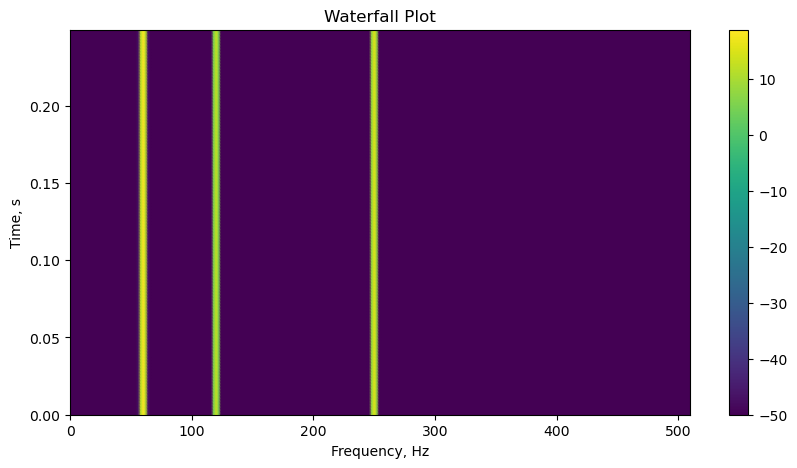

In [25]:
fig = plt.figure(figsize=(10,5))
ax = plt.axes()
im = plt.pcolormesh(freqs, np.arange(int(L/N))/fs, Xlog, vmin=-50, shading='gouraud')
ax.set_xlabel('Frequency, Hz')
ax.set_ylabel('Time, s')
ax.set_title('Waterfall Plot')
fig.colorbar(im)
plt.show()

### 3.1. STFT of a Chirp <a class="anchor" id="stft-of-a-chirp"></a>

We can also perform a frequency sweep by taking the STFT of a chirp signal. A chirp is a type of signal that increases or decreases in frequency over time. Here, we construct an up-chirp, by passing a vector of increasing frequency values to our sine function.

/var/folders/y_/4y9gzpnx6xx2bxstv0jtcl9h0000gn/T/ipykernel_12998/4018461594.py:10: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  axes.stem(x[idx], y[idx], use_line_collection = True)


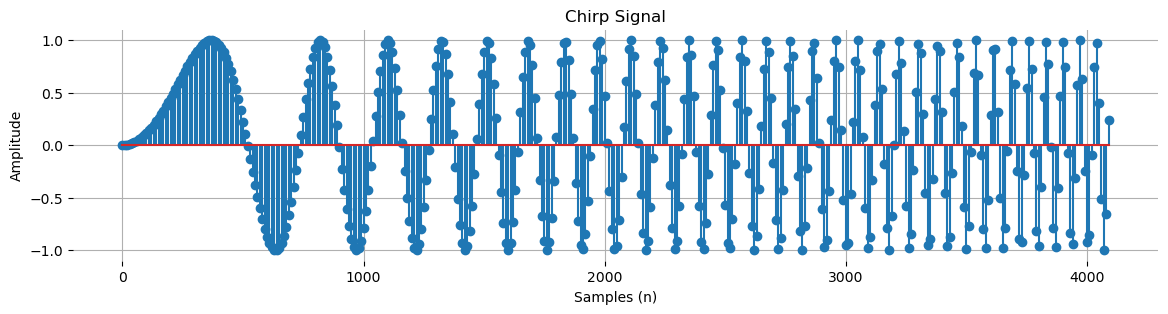

In [26]:
# Set basic params
fs = 1024 # sample rate
N = 512 # fft size
L = N*256 # we want 256 frames of 512 FFT windows

# Frequency increases over time
f = 0.0019*np.arange(L)

# Create a sampled sinusoid and corresponding frequencies for plotting
chirp = np.sin(2*np.pi*f*np.arange(L)/fs)

# Plot the chirp signal
stem_plot(x      = [np.arange(0, 4096, 10)],
          y      = [chirp[:4096:10]],
          xticks = [np.arange(0, 4096, 1000)],
          figsize= (14, 3),
          title  = ["Chirp Signal"], 
          xlabel = ["Samples (n)"], 
          ylabel = ["Amplitude"])

Performing the same steps as we did for our sum of sines, we visualize the frequency sweep in the waterfall plot.

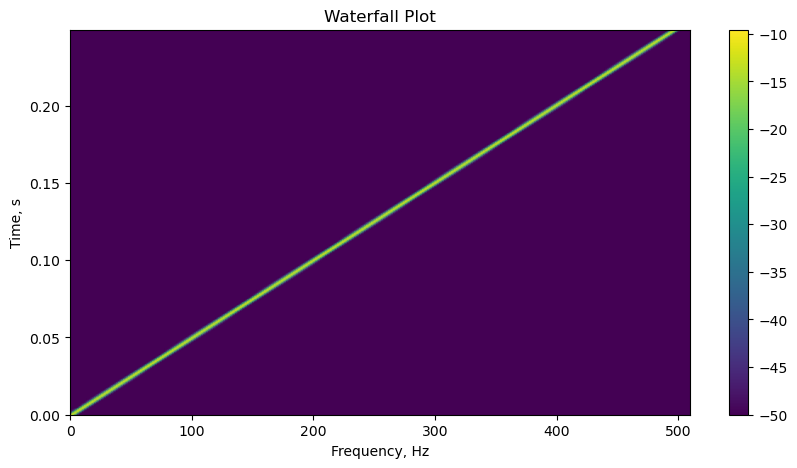

In [27]:
# Slice it up into 512-sized chunks
chirp = chirp.reshape(-1,N)
chirp.shape

# Compute FFT and calculate the PSD
X = np.fft.fft(chirp*np.hamming(N), N)[:,:int(N/2)]
Xlog = 10*np.log10(2*np.abs(X)**2/N/fs)

# Get corresponding frequencies, take only positive spectrum
freqs = np.fft.fftfreq(N,1/fs)[:int(N/2)]

fig = plt.figure(figsize=(10,5))
ax = plt.axes()
im = plt.pcolormesh(freqs, np.arange(int(L/N))/fs, Xlog, vmin=-50, shading='gouraud')
ax.set_xlabel('Frequency, Hz')
ax.set_ylabel('Time, s')
ax.set_title('Waterfall Plot')
fig.colorbar(im)
plt.show()

This simple example demonstrates the functionality of a waterfall plot in observing the spectra of a discrete waveform over time. As shown, the frequency of the waveform increases as a function of time by observing the amplitude of the log-scale magnitude.

[⬅️ Previous Notebook](06_investigating_the_dft.ipynb) || [Next Notebook 🚀](08_amplitude_modulation.ipynb)
